# Tutorial Image Classification

In this tutorial, we show how the Selector library can be used for image classification tasks. We
will select different percentages of the MINST dataset and evaluate the performances of a simple
support vector machine (SVM) classifier on the selected subsets. We will compare the results of
different selection methods with the random selection baseline.


In [1]:
# based on https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html
import matplotlib.pyplot as plt

import numpy as np
from sklearn import datasets, metrics, svm
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from selector.methods import MaxMin, MaxSum, DISE, OptiSim, GridPartition

In [2]:
# load dataset
digits = datasets.load_digits()
data = digits.images.reshape((len(digits.images), -1))

In [3]:
# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.4, shuffle=True, random_state=42
)

In [4]:
# set up the selection methods
methods = {
    "MaxMin": MaxMin(),
    "MaxSum": MaxSum(),
    "DISE": DISE(ref_index=0, p=2.0),
    "OptiSim": OptiSim(ref_index=0, tol=0.1),
}

In [5]:
# define the percentages of data to select
percentages = np.linspace(0.05, 1.0, 15)
sizes = [int(p * X_train.shape[0]) for p in percentages]

In [6]:
# compute the pairwise distance of X_train
X_train_dist = pairwise_distances(X_train)

In [ ]:
# perform the subset selection and classification
results_accuracies = {}
results_f1_scores = {}

for method_name in methods.keys():
    results_accuracies[method_name] = []
    results_f1_scores[method_name] = []

# Run experiments and store results
for method_name, method in methods.items():
    print(f"Method: {method_name}")
    method_accuracies = []
    method_f1_scores = []
    for p, size in zip(percentages, sizes):
        if p == 1.0:
            # use the whole training set
            X_train_reduced = X_train
            y_train_reduced = y_train

        # when p > 0.5, we can select the samples to drop instead of to keep to speed up
        elif p > 0.5 and p < 1.0:
            p_tmp = 1.0 - p
            size_tmp = int(p_tmp * X_train.shape[0])
            # select a subset of the training set to remove
            picker = method
            selected_indices_to_drop = picker.select(X_train_dist, size=size_tmp)
            # get the selected indices to keep
            selected_indices = np.setdiff1d(np.arange(X_train.shape[0]), selected_indices_to_drop)
            X_train_reduced = X_train[selected_indices]
            y_train_reduced = y_train[selected_indices]

        else:
            # select a subset of the training set
            picker = method
            selected_indices = picker.select(X_train_dist, size=size)
            X_train_reduced = X_train[selected_indices]
            y_train_reduced = y_train[selected_indices]

        actual_percentage = X_train_reduced.shape[0] / X_train.shape[0]

        # create a support vector classifier
        clf = svm.SVC(gamma=0.001)
        clf.fit(X_train_reduced, y_train_reduced)
        y_test_pred = clf.predict(X_test)

        accuracy = metrics.accuracy_score(y_test, y_test_pred)
        method_accuracies.append((actual_percentage, accuracy))
        print(f"  Percentage: {actual_percentage:.2f}, Accuracy: {accuracy:.4f}")

        f1 = metrics.f1_score(y_test, y_test_pred, average="weighted")
        method_f1_scores.append((actual_percentage, f1))

    results_accuracies[method_name] = method_accuracies
    results_f1_scores[method_name] = method_f1_scores

In [8]:
# add random selection as baseline
print("Method: Random")
random_accuracies = []
random_f1_scores = []

for p, size in zip(percentages, sizes):
    random_accuracies_tmp = []
    random_f1_scores_tmp = []

    for i in range(10):  # Run 10 trials
        rng = np.random.default_rng(seed=42 + i)
        random_indices = rng.choice(X_train.shape[0], size=size, replace=False)
        X_train_reduced = X_train[random_indices]
        y_train_reduced = y_train[random_indices]

        clf = svm.SVC(gamma=0.001)
        clf.fit(X_train_reduced, y_train_reduced)
        y_test_pred = clf.predict(X_test)

        accuracy = metrics.accuracy_score(y_test, y_test_pred)
        random_accuracies_tmp.append(accuracy)
        f1 = metrics.f1_score(y_test, y_test_pred, average="weighted")
        random_f1_scores_tmp.append(f1)

    accuracy = np.mean(random_accuracies_tmp)
    random_accuracies.append((p, accuracy))
    f1_score = np.mean(random_f1_scores_tmp)
    random_f1_scores.append((p, f1_score))
    print(f"Percentage: {p:.2f}, Accuracy: {accuracy:.4f}")

results_accuracies["Random"] = random_accuracies
results_f1_scores["Random"] = random_f1_scores

Method: Random
Percentage: 0.05, Accuracy: 0.7224
Percentage: 0.12, Accuracy: 0.9209
Percentage: 0.19, Accuracy: 0.9480
Percentage: 0.25, Accuracy: 0.9651
Percentage: 0.32, Accuracy: 0.9733
Percentage: 0.39, Accuracy: 0.9803
Percentage: 0.46, Accuracy: 0.9834
Percentage: 0.53, Accuracy: 0.9855
Percentage: 0.59, Accuracy: 0.9857
Percentage: 0.66, Accuracy: 0.9878
Percentage: 0.73, Accuracy: 0.9900
Percentage: 0.80, Accuracy: 0.9907
Percentage: 0.86, Accuracy: 0.9905
Percentage: 0.93, Accuracy: 0.9917
Percentage: 1.00, Accuracy: 0.9930


In [9]:
markers = ["o", "*", "^", "s", "p", "x", ">", "<", "|", "v", "_"]

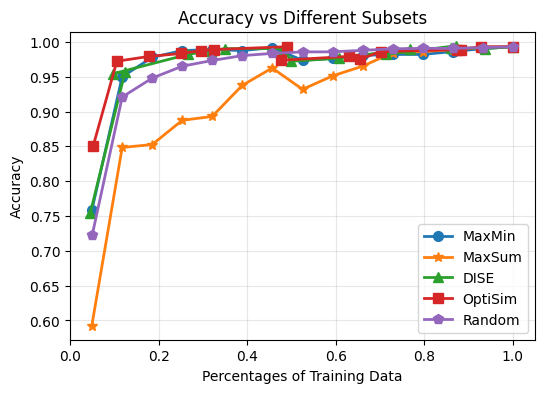

In [10]:
# Plot the results for accuracies
plt.figure(figsize=(6, 4))

for idx, (method_name, accuracies) in enumerate(results_accuracies.items()):
    plt.plot(
        [a[0] for a in accuracies],
        [a[1] for a in accuracies],
        marker=markers[idx],
        label=method_name,
        linewidth=2,
        markersize=7,
    )

plt.xlabel("Percentages of Training Data")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1.05)
# plt.ylim(0.75, 1.00)
plt.title("Accuracy vs Different Subsets")

# save the figure
plt.show()

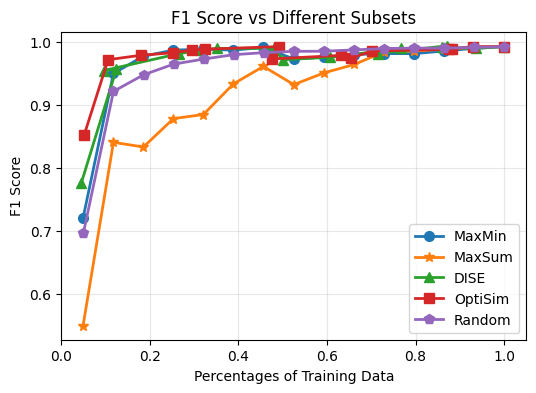

In [11]:
# Plot the results for F1 scores
plt.figure(figsize=(6, 4))
for idx, (method_name, f1_scores) in enumerate(results_f1_scores.items()):
    plt.plot(
        [a[0] for a in f1_scores],
        [a[1] for a in f1_scores],
        marker=markers[idx],
        label=method_name,
        linewidth=2,
        markersize=7,
    )

plt.xlabel("Percentages of Training Data")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1.05)
# plt.ylim(0.75, 1.00)
plt.title("F1 Score vs Different Subsets")

# save the figure
plt.show()

Based on the results, we can notiece that:
- Selecting subsets of data can achieve comparable performance to using the full dataset. For
  example, selecting ~20% of data, different selection methods can achieve over 95% accuracy (except
  MaxSum). This holds for F1 scores as well.
- Random sampling performance is not satisfactory when the subset size is small. For example, when
  selecting only 5% of data, random sampling achieves only around 70% accuracy and F1 score of 0.7, 
  while other methods are better. This trends hold until the subset size reaches around 50%. Once we
  have enough data as training subset, we noticed that random sampling can achieve comparable performance
  to other methods. This is because we have enough data to cover the data distribution well with random
  sampling in such cases. Therefore, these subset selection methods are more useful when we have limited
  labeling budget and can only select small subsets of data for training.
- The MaxSum algorithm consistently underperforms compared to other selection methods across different subset sizes.
  This suggests that MaxSum may not be as effective for selecting representative subsets of data
  for image classification tasks on the MNIST dataset as it tends to select outliers or less
  informative samples. This indicates the potential usage of MaxSum for outlier detection tasks.

*Limitations*

This tutorial uses a simple SVM classifier for demonstration purposes. In practice, more advanced
neural network architectures should be used for image classification tasks to achieve better
performance.
The dataset used in this tutorial is the MNIST dataset from scikit-learn, which is
relatively simple and small.
To better evaluate the effectiveness of different subset selection methods, larger and more
complex datasets such as CIFAR-10 or ImageNet should be used in practice. Papers such as:
[Grad-Match: Gradient Matching Based Data Subset Selection for Efficient Deep Model Training,
International Conference on Machine Learning,
2021](https://proceedings.mlr.press/v139/killamsetty21a/killamsetty21a.pdf) and [Dataset Efficient
Training with Model Ensembling, IEEE Computer Society Conference on Computer Vision and Pattern
Recognition Workshops (CVPRW), 2023](https://openaccess.thecvf.com/content/CVPR2023W/ECV/html/Ro_Dataset_Efficient_Training_With_Model_Ensembling_CVPRW_2023_paper.html).